## MDS616 - Assessment 4 - Group Project - DQN algorithms for Cart Pole game

**Author: Xiuwen ZHENG** <br>
**Date: 12/05/2024** <br>
**Course: MDS616 - Reinforcement Learning** <br>
**Tutor: Anjin Liu**

In [1]:
import gym
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import matplotlib.pyplot as plt
#from IPython.display import clear_output
from IPython import display
import random

### Part 1: Load the gymanium environment and check the data

In [2]:
# use gymnasium CartPole-v1 encironment, render mode is rgb_array
env = gym.make("CartPole-v1")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# reset the environment
env.reset()

array([-0.00721705, -0.00718679, -0.04909711, -0.04977763], dtype=float32)

In [4]:
# convert env to a contiguous array and plot a picture
# please pip install gym<=0.26.0, I recommened 0.23.0
screen = env.render('rgb_array')
screen = np.ascontiguousarray(screen, dtype = np.float32) / 255

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


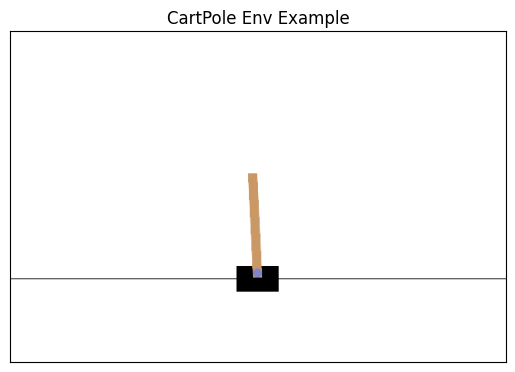

In [5]:
plt.figure()
plt.imshow(screen)
plt.title("CartPole Env Example")
plt.xticks([])
plt.yticks([])
plt.show()

### Part 2: Baseline Model and Deep Q learning

#### 1. Baseline Model —— Random Policy

In [6]:
# define a funtion to plot the results
def plot_result(values, title=""):
    # draw a new picture when freshing
    plt.pause(0.02)
    display.clear_output(wait=True)

    fig, ax = plt.subplots(1,2, figsize=(10,5) ) # 2 subplots in one figure
    fig.suptitle(title)

    # plot 1 -- rewards per episode
    ax[0].plot(values, label="rewards per episode")
    ax[0].axhline(200, c='red', label='goal')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')
    ax[0].legend()

    # plot 2 -- mean reward of the lst 50 episodes
    ax[1].set_title("mean reward = {}".format(sum(values[-50:])/50))
    ax[1].hist(values[-50:])
    ax[1].axvline(200, c='red', label='goal')
    ax[1].set_xlabel('Reward per last 50 episodes')
    ax[1].set_ylabel('frenquency')
    ax[1].legend()

plt.show()


In [7]:
# random policy
def random_policy(env, episodes):
    rewards = []
    for _ in range(episodes):
        env.reset()
        total_reward = 0
        done = False # whether the episodes ends
        while not done:
            action = env.action_space.sample() # randomly sample
            next_state, reward, done, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
        plot_result(rewards)
    env.close()

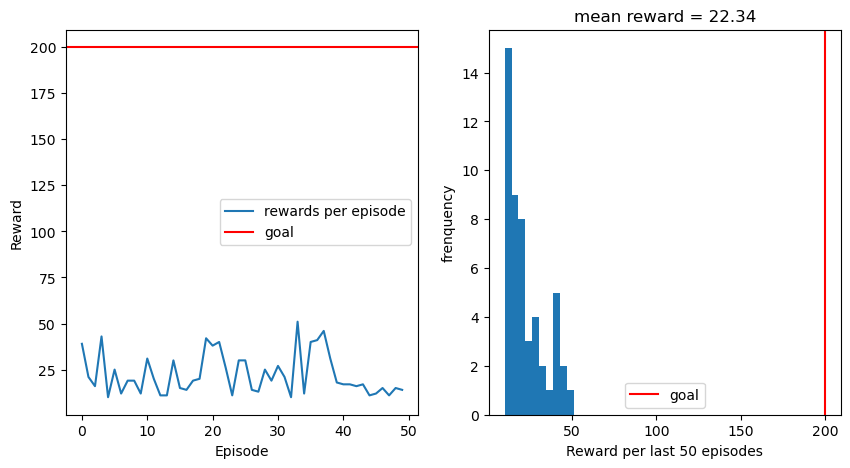

In [ ]:
random_policy(env, 50)

#### Part 2: Deep Q Learning

We defined a deep Q learning class which contains the structure of a neural network, a update function and a predict function.

In [8]:
print(torch.__path__)

['/usr/local/lib/python3.10/dist-packages/torch']


In [12]:
class DQN:
    def __init__(self, state_dim, action_dim, hidden_dim = 64, lr=0.001):
        """
        state_dim: input dimensions
        action_dim: output dimension(s)
        hidden_dim: set 64 hidden dimensions
        lr: learning rate
        """
        # define a Neural Network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim*2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim*2, action_dim)
        )
        self.criterion = torch.nn.MSELoss() # use MSE as criterion
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) # use Adam optimizer

    def update(self, state, q):
        q_pred = self.model(torch.Tensor(state)) # predict q value
        loss = self.criterion(q_pred, torch.Tensor(q)) # calculate loss function
        self.optimizer.zero_grad() # reset the gradient to 0
        loss.backward() # backward process
        self.optimizer.step() # update the optimizer

    def predict(self, state:np.ndarray) -> torch.Tensor:
        with torch.no_grad():
            return self.model(torch.Tensor(state)) # prediction value should not be regarded as the "update value"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We defined a **DQN** function with the epsilon greedy policy.

In [18]:
def DQN_process(env, model, episodes, gamma=0.9, epsilon=0.3, epsilon_decay=0.99, title="DQN_model"):
    """
    env: environment
    gamma: Markov procession gamma
    epsilon: we use epsilon greedy algorithm
    epsilon_decay: epsilon decay rate
    """
    rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            # epsilon greedy: if the random value less than epsilon, choose the random value, otherwise use the predict value
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item() # find the maximum item in q_values by their index

            next_state, reward, done, info = env.step(action) # the four parameters by doing step"action"
            total_reward += reward

            q_values = model.predict(state)
            # q value of the current step = former reward + gamma * the best prediction
            # tell the agend the episode if it is end
            q_values[action] = (reward + (0 if done else gamma * torch.max(model.predict(next_state)).item()) )
            model.update(state, q_values) # update the model base on the new q value
            state = next_state # jump to the next state

        epsilon = max(epsilon * epsilon_decay, 0.001) # epsilon decay until 0.001
        rewards.append(total_reward)
        plot_result(rewards)


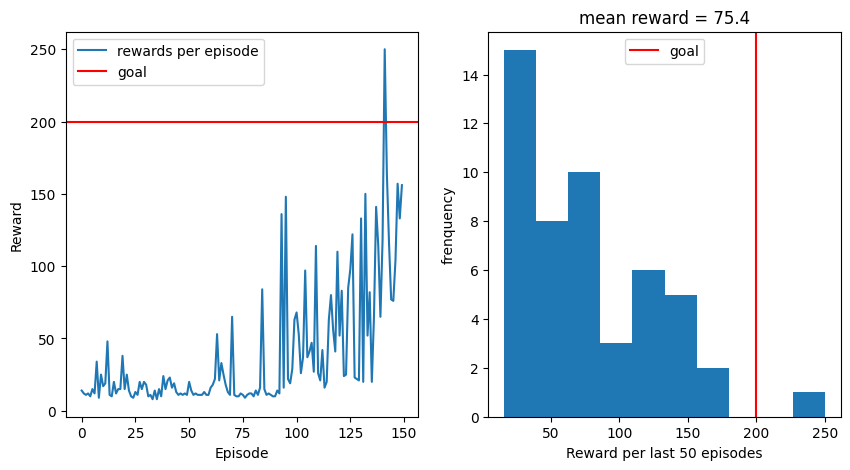

In [17]:
dqn = DQN(state_dim=4, action_dim=2, hidden_dim = 64, lr=0.001)
DQN_process(env=env, model=dqn, episodes=150, gamma=0.9, epsilon=0.5)